In [1]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

x_test = np.load('/home/jovyan/UNSW/x_test.npy',allow_pickle=True)
x_train = np.load('/home/jovyan/UNSW/x_train.npy',allow_pickle=True)
x_val = np.load('/home/jovyan/UNSW/x_val.npy',allow_pickle=True)
y_test = np.load('/home/jovyan/UNSW/y_test.npy',allow_pickle=True)
y_train = np.load('/home/jovyan/UNSW/y_train.npy',allow_pickle=True)
y_val = np.load('/home/jovyan/UNSW/y_val.npy',allow_pickle=True)

In [3]:
# gnb_org = GaussianNB()
# gnb_org.fit(x_train, y_train)
# y_pred_org = gnb_org.predict(x_test)

# accuracy_gnb = accuracy_score(y_test, y_pred_org)
# micro_f1_gnb = f1_score_rep(y_test, y_pred_org, average="micro")
# macro_f1_gnb = f1_score_rep(y_test, y_pred_org, average="macro")

# print(f'Gaussian Naive Bayes Test Accuracy: {accuracy_gnb * 100:.2f}%')
# print(f'Gaussian Naive Bayes Micro F1 Score: {micro_f1_gnb}')
# print(f'Gaussian Naive Bayes Macro F1 Score: {macro_f1_gnb}')

In [4]:



# 定义参数
gnb_params = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_gnb(x_train, y_train, param_grid):
    gnb = GaussianNB()

    start = time()
    halving_gnb_results = HalvingGridSearchCV(
        gnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_gnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_gnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_gnb(x_val, y_val, gnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 GNB 模型
best_gnb = GaussianNB(**best_params)
best_gnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_gnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_gnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_gnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


     iter  rank_test_score  mean_test_score  \
200     6               67         0.435607   
199     6               68         0.434709   
198     5               53         0.437522   
195     5               63         0.436637   
196     5               65         0.436215   

                                       params  
200   {'var_smoothing': 0.002848035868435802}  
199  {'var_smoothing': 0.0005336699231206307}  
198   {'var_smoothing': 0.002848035868435802}  
195  {'var_smoothing': 0.0005336699231206307}  
196  {'var_smoothing': 0.0003511191734215131}  
Best score for HalvingGridSearchCV is 0.436, took 12.45 seconds
Params: {'var_smoothing': 0.002848035868435802}
Corresponding test accuracy: 43.60%
Micro F1 Score:  0.4360417700366714
Macro F1 Score:  0.12450715456276913


FPR: [0.         0.         0.00156981 0.         0.01434235 0.42332331
 0.32748175 0.         0.         0.        ]
TPR: [0.00000000e+00 0.00000000e+00 8.15394651e-04 0.00000000e+00
 7.22063352e-02 9.86500000e-01 6.37017857e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
FNR: [1.         1.         0.99918461 1.         0.92779366 0.0135
 0.36298214 1.         1.         1.        ]
TNR: [1.         1.         0.99843019 1.         0.98565765 0.57667669
 0.67251825 1.         1.         1.        ]
Precision: 0.12907319249966456
Accuracy: 0.4360417700366714
F1-score: 0.3185512003979151
AUC: 0.641387156875677
FPR: 0.07667172193689992
tpr: 0.16965395870336392
fnr: 0.8303460412966361
tnr: 0.9233282780631


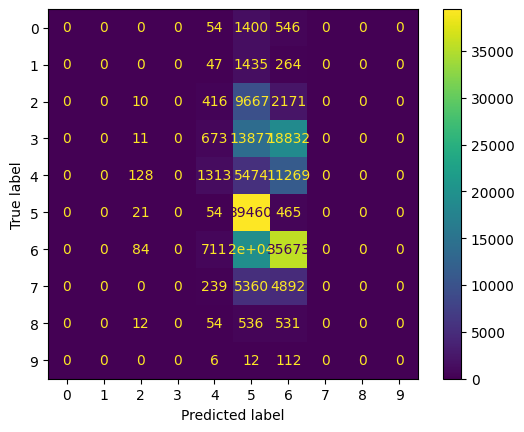

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_gnb = GaussianNB(var_smoothing = 1.873817422860383e-06)
# best_gnb.fit(x_train, y_train)

y_pred = best_gnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_gnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "gnb",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a', index=False)

In [6]:
# mnb_org = MultinomialNB()
# mnb_org.fit(x_train, y_train)
# y_pred_mnb = mnb_org.predict(x_test)

# accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
# micro_f1_mnb = f1_score_rep(y_test, y_pred_mnb, average="micro")
# macro_f1_mnb = f1_score_rep(y_test, y_pred_mnb, average="macro")

# print(f'Multinomial Naive Bayes Test Accuracy: {accuracy_mnb * 100:.2f}%')
# print(f'Multinomial Naive Bayes Micro F1 Score: {micro_f1_mnb}')
# print(f'Multinomial Naive Bayes Macro F1 Score: {macro_f1_mnb}')

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
mnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100)  # alpha 值从 0 到 1
}

# # 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_mnb(x_train, y_train, param_grid):
    mnb = MultinomialNB()

    start = time()
    halving_mnb_results = HalvingGridSearchCV(
        mnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_mnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_mnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_mnb(x_val, y_val, mnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 MNB 模型
best_mnb = MultinomialNB(**best_params)
best_mnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_mnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_mnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_mnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


     iter  rank_test_score  mean_test_score                           params
199     6                1         0.415412  {'alpha': 0.010101010101010102}
200     6                1         0.415412                   {'alpha': 0.0}
195     5                3         0.365288   {'alpha': 0.21212121212121213}
196     5                3         0.365288    {'alpha': 0.4747474747474748}
197     5                3         0.365288  {'alpha': 0.010101010101010102}
Best score for HalvingGridSearchCV is 0.415, took 32.07 seconds
Params: {'alpha': 0.010101010101010102}
Corresponding test accuracy: 45.86%
Micro F1 Score:  0.4585921147934597
Macro F1 Score:  0.1289639406168675


FPR: [4.97285697e-03 0.00000000e+00 9.33301447e-03 1.05672500e-04
 2.53886241e-03 3.74143829e-01 3.33682473e-01 0.00000000e+00
 1.72207935e-05 9.53707244e-03]
TPR: [0.0095     0.         0.037182   0.00176684 0.00445447 0.986925
 0.71994643 0.         0.         0.00769231]
FNR: [0.9905     1.         0.962818   0.99823316 0.99554553 0.013075
 0.28005357 1.         1.         0.99230769]
TNR: [0.99502714 1.         0.99066699 0.99989433 0.99746114 0.62585617
 0.66631753 1.         0.99998278 0.99046293]
Precision: 0.21599144979976304
Accuracy: 0.4585921147934596
F1-score: 0.3337954189133497
AUC: 0.5520980855930497
FPR: 0.07343310017884358
tpr: 0.17674670351751098
fnr: 0.8232532964824889
tnr: 0.9265668998211563


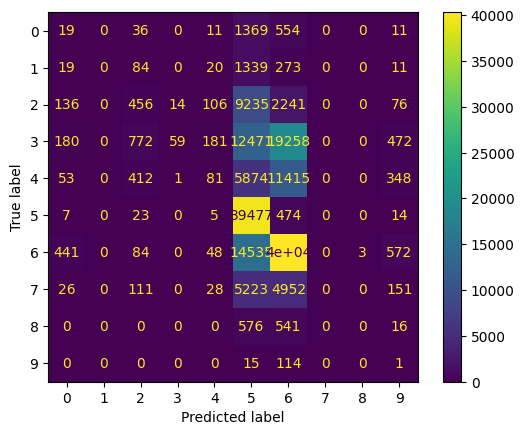

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_mnb = MultinomialNB(alpha= 0.0)
# best_mnb.fit(x_train, y_train)

y_pred = best_mnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_mnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "mnb",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a',header = False, index=False)

In [9]:
# cnb_org = ComplementNB()
# cnb_org.fit(x_train, y_train)
# y_pred_cnb = cnb_org.predict(x_test)

# accuracy_cnb = accuracy_score(y_test, y_pred_cnb)
# micro_f1_cnb = f1_score_rep(y_test, y_pred_cnb, average="micro")
# macro_f1_cnb = f1_score_rep(y_test, y_pred_cnb, average="macro")

# print(f'Complement Naive Bayes Test Accuracy: {accuracy_cnb * 100:.2f}%')
# print(f'Complement Naive Bayes Micro F1 Score: {micro_f1_cnb}')
# print(f'Complement Naive Bayes Macro F1 Score: {macro_f1_cnb}')

In [10]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
cnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100)  # alpha 值从 0 到 1
}

# # 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_cnb(x_train, y_train, param_grid):
    cnb = ComplementNB()

    start = time()
    halving_cnb_results = HalvingGridSearchCV(
        cnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_cnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_cnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_cnb(x_val, y_val, cnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 CNB 模型
best_cnb = ComplementNB(**best_params)
best_cnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_cnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_cnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_cnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)

     iter  rank_test_score  mean_test_score                          params
199     6              164         0.503331  {'alpha': 0.36363636363636365}
200     6              164         0.503331                  {'alpha': 1.0}
195     5              166         0.502418  {'alpha': 0.20202020202020204}
196     5              166         0.502418  {'alpha': 0.21212121212121213}
197     5              166         0.502418  {'alpha': 0.36363636363636365}
Best score for HalvingGridSearchCV is 0.503, took 34.48 seconds
Params: {'alpha': 0.36363636363636365}
Corresponding test accuracy: 52.77%
Micro F1 Score:  0.5277031612686137
Macro F1 Score:  0.14012842622448035


FPR: [0.         0.         0.         0.00938372 0.         0.29096135
 0.35278739 0.         0.         0.        ]
TPR: [0.         0.         0.         0.02198065 0.         0.986775
 0.93433929 0.         0.         0.        ]
FNR: [1.         1.         1.         0.97801935 1.         0.013225
 0.06566071 1.         1.         1.        ]
TNR: [1.         1.         1.         0.99061628 1.         0.70903865
 0.64721261 1.         1.         1.        ]
Precision: 0.14099816009274618
Accuracy: 0.5277031612686137
F1-score: 0.38159098090228866
AUC: 0.5656234524302414
FPR: 0.06531324582156597
tpr: 0.19430949403425013
fnr: 0.8056905059657499
tnr: 0.9346867541784342


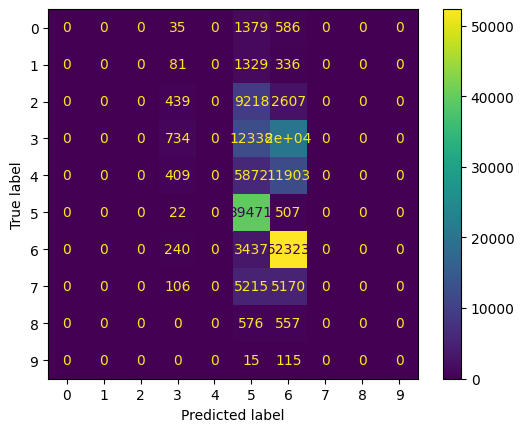

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_cnb = ComplementNB(alpha= 0.010101010101010102)
# best_cnb.fit(x_train, y_train)

y_pred = best_cnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_cnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "cnb",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a',header = False, index=False)

In [12]:
# bnb_org = BernoulliNB()
# bnb_org.fit(x_train, y_train)
# y_pred_bnb = bnb_org.predict(x_test)

# accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
# micro_f1_bnb = f1_score_rep(y_test, y_pred_bnb, average="micro")
# macro_f1_bnb = f1_score_rep(y_test, y_pred_bnb, average="macro")

# print(f'Bernoulli Naive Bayes Test Accuracy: {accuracy_bnb * 100:.2f}%')
# print(f'Bernoulli Naive Bayes Micro F1 Score: {micro_f1_bnb}')
# print(f'Bernoulli Naive Bayes Macro F1 Score: {macro_f1_bnb}')

In [13]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
bnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100),  # alpha 值从 0 到 1
    'binarize': np.linspace(0.0, 1.0, num=20)  # binarize 阈值
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_bnb(x_train, y_train, param_grid):
    bnb = BernoulliNB()

    start = time()
    halving_bnb_results = HalvingGridSearchCV(
        bnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_bnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_bnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_bnb(x_val, y_val, bnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 BNB 模型
best_bnb = BernoulliNB(**best_params)
best_bnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_bnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_bnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_bnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


      iter  rank_test_score  mean_test_score  \
3997     9              386         0.705704   
3995     9              389         0.704874   
3994     9              391         0.704614   
3996     9              392         0.704478   
3987     8              297         0.710014   

                                              params  
3997  {'alpha': 0.0, 'binarize': 0.6842105263157894}  
3995  {'alpha': 0.0, 'binarize': 0.7368421052631579}  
3994  {'alpha': 0.0, 'binarize': 0.8421052631578947}  
3996   {'alpha': 0.0, 'binarize': 0.894736842105263}  
3987  {'alpha': 0.0, 'binarize': 0.6842105263157894}  
Best score for HalvingGridSearchCV is 0.706, took 161.21 seconds
Params: {'alpha': 0.0, 'binarize': 0.6842105263157894}
Corresponding test accuracy: 63.04%
Micro F1 Score:  0.6304230043173017
Macro F1 Score:  0.22766285452710253


FPR: [0.00054805 0.00180305 0.01601084 0.12552484 0.00497592 0.2531827
 0.         0.         0.         0.05089292]
TPR: [0.0025     0.0091638  0.07093933 0.42191477 0.00159481 0.98625
 1.         0.         0.         0.61538462]
FNR: [0.9975     0.9908362  0.92906067 0.57808523 0.99840519 0.01375
 0.         1.         1.         0.38461538]
TNR: [0.99945195 0.99819695 0.98398916 0.87447516 0.99502408 0.7468173
 1.         1.         1.         0.94910708]
Precision: 0.23699370962417854
Accuracy: 0.6304230043173017
F1-score: 0.5681074583107157
AUC: 0.8616765957385496
FPR: 0.04529383222577117
tpr: 0.3107747334180904
fnr: 0.6892252665819096
tnr: 0.9547061677742288


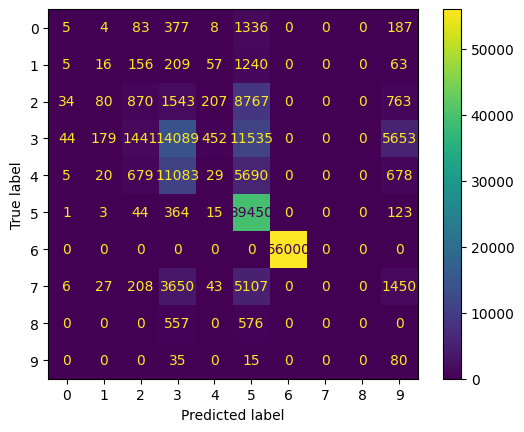

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_bnb = BernoulliNB(alpha=0.0, binarize=0.10526315789473684)
# best_bnb.fit(x_train, y_train)

y_pred = best_bnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_bnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_bnb.classes_)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "bnb",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a',header = False, index=False)

In [15]:
# ctnb_org = CategoricalNB()
# ctnb_org.fit(x_train, y_train)
# y_pred_ctnb = ctnb_org.predict(x_test)

# accuracy_ctnb = accuracy_score(y_test, y_pred_ctnb)
# micro_f1_ctnb = f1_score_rep(y_test, y_pred_ctnb, average="micro")
# macro_f1_ctnb = f1_score_rep(y_test, y_pred_ctnb, average="macro")

# print(f'Categorical Naive Bayes Test Accuracy: {accuracy_ctnb * 100:.2f}%')
# print(f'Categorical Naive Bayes Micro F1 Score: {micro_f1_ctnb}')
# print(f'Categorical Naive Bayes Macro F1 Score: {macro_f1_ctnb}')

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
ctnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100)  # alpha 值从 0 到 1
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_ctnb(x_train, y_train, param_grid):
    ctnb = CategoricalNB()

    start = time()
    halving_ctnb_results = HalvingGridSearchCV(
        ctnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_ctnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_ctnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_ctnb(x_val, y_val, ctnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 CTNB 模型
best_ctnb = CategoricalNB(**best_params)
best_ctnb.fit(x_train, y_train)

# # 在测试集上评估
accuracy = accuracy_score(y_test, best_ctnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_ctnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_ctnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_ctnb = CategoricalNB()
# best_ctnb.fit(x_train, y_train)

y_pred = best_ctnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_ctnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()


import pandas as pd
metrics = {
    "model" : "ctnb",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a', index=False)